## Description
This introductory notebook demonstrates how to visualise satellite data returned from running a datacube query. The notebook demonstrates commonly-used xarray plotting methods, as well as custom functions provided in tools.plotting.

Topics covered in this notebook include:

* View your area of interest prior to querying the datacube
* Querying the datacube and loading data
* Plotting single band data (e.g. a single satellite band)
* Selecting and plotting individual timesteps
* Plotting multiple timesteps
* Customising plot appearance
* Plotting three-band true or false colour imagery
* Plotting single timesteps
* Plotting multiple timesteps
* Customising plot appearance

In [1]:
%matplotlib inline
import sys
sys.path.insert(1, '../tools/')
import datacube
from tools.plotting import rgb, display_map
from odc.ui import with_ui_cbk
from tools.datahandling import load_ard, mostcommon_crs

In [2]:
dc = datacube.Datacube(app='Sentinel_2')

In [3]:
lon_range = (31.7, 31.9)
lat_range = (30.5, 30.9)

## View the queried location
Before running a query and extracting and analysing data, it is useful to double-check that your location is correct. The display_map() function shows your selected area as a red rectangle on an interactive map. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

/notebooks/tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


In [5]:
lat, lon = 30.5, 31.7
buffer = 0.125

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2022-01-01', '2022-01-31'),
    'resolution': (-20, 20)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)
print(output_crs)

# Load available data from Sentinel-2 and filter to retain only times
# with at least 90% good data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              min_gooddata=0.9, 
              measurements=['red', 'green', 'blue', 'swir_1', 'swir_2', 'nir', 'nir_2'],
              output_crs=output_crs,
              progress_cbk=with_ui_cbk(),
              **query)

epsg:32636


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 4 out of 6 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


In [6]:
print(ds.red)

<xarray.DataArray 'red' (time: 4, y: 1400, x: 1217)>
array([[[ 286.,  343.,  401., ..., 1052.,  725.,  698.],
        [ 287.,  369.,  355., ...,  594.,  727.,  697.],
        [ 423.,  315.,  351., ...,  629.,  674.,  606.],
        ...,
        [1848., 2380., 1516., ..., 2461., 2177.,  831.],
        [2168., 1773., 1964., ..., 2029., 2296., 1318.],
        [2361., 2038., 1904., ..., 2665., 2093., 1803.]],

       [[ 174.,  251.,  289., ..., 1063.,  653.,  594.],
        [ 197.,  326.,  202., ...,  485.,  657.,  622.],
        [ 364.,  221.,  200., ...,  539.,  651.,  519.],
        ...,
        [1661., 2114., 1383., ..., 2528., 2135.,  708.],
        [1973., 1630., 1888., ..., 2097., 2351., 1314.],
        [2249., 1989., 1906., ..., 2655., 2150., 1795.]],

       [[ 208.,  237.,  286., ..., 1231.,  705.,  572.],
        [ 211.,  275.,  194., ...,  431.,  582.,  666.],
        [ 344.,  255.,  172., ...,  514.,  605.,  526.],
        ...,
        [1733., 2490., 1396., ..., 2501., 2193., 

## Selecting and plotting a single timestep
You can see in the object header that this xarray.DataArray has data for six timesteps (i.e. <xarray.DataArray 'red' (time: 6, y: 1394, x: 1028)>). To make a plot for a single timestep only, we need to select it using one of the following options:

.isel(): This stands for "index selection", and lets us easily select individual timesteps from a dataset by providing the number of the observation we want.
Counting in Python begins at 0, so to select the first timestep in the xarray.DataArray we can specify .isel(time=0):

In [7]:
first_timestep = ds.red.isel(time=0)
print(first_timestep)

<xarray.DataArray 'red' (y: 1400, x: 1217)>
array([[ 286.,  343.,  401., ..., 1052.,  725.,  698.],
       [ 287.,  369.,  355., ...,  594.,  727.,  697.],
       [ 423.,  315.,  351., ...,  629.,  674.,  606.],
       ...,
       [1848., 2380., 1516., ..., 2461., 2177.,  831.],
       [2168., 1773., 1964., ..., 2029., 2296., 1318.],
       [2361., 2038., 1904., ..., 2665., 2093., 1803.]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2022-01-03T08:41:48
  * y            (y) float64 3.389e+06 3.389e+06 ... 3.361e+06 3.361e+06
  * x            (x) float64 3.631e+05 3.631e+05 ... 3.874e+05 3.874e+05
    spatial_ref  int32 32636
Attributes:
    units:         1
    nodata:        0
    crs:           epsg:32636
    grid_mapping:  spatial_ref


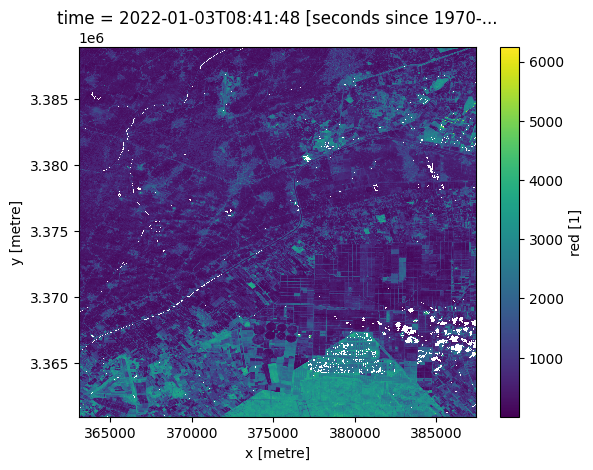

In [8]:
first_timestep.plot()

## Plotting true or false colour RGB images
Although xarray makes it easy to plot single band images, plotting a three band colour photo-like image is less straightforward.

To make this easier, repository provides a custom rgb() function that is designed for plotting three band images. The rgb() function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.

Providing the red, green and blue measurements from a dataset will produce a true colour image (akin to how humans view the landscape). Providing nir, red and green measurements or any other set of three satellite bands from a dataset will produce a false colour image.

Hence, the rgb() function can be used to visualise the data returned by a query. It requires the minimum input of:

* ds: The xarray.Dataset object
* bands: Three bands for display (these must be measurements found in the dataset)
* index: The timestep to view, default is 0


## Plotting a multiple timestep
The time dimension of your xarray.Dataset describes how many timesteps exist for your location during your nominated time period. In the rgb() function, the index variable is asking for which timestep you want to view (similar to the isel() example above).

/usr/local/lib/python3.8/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


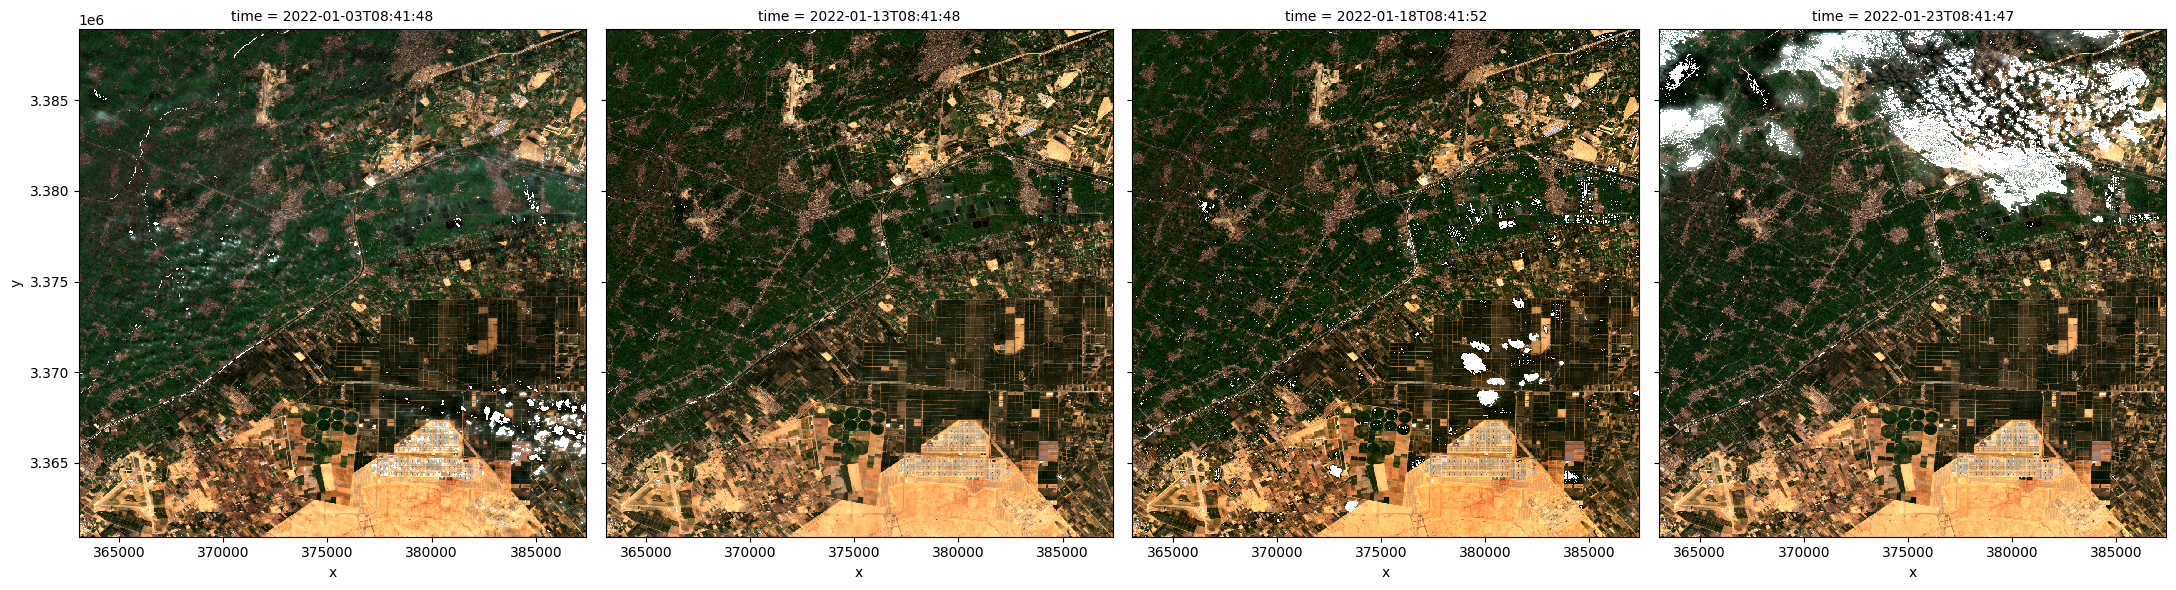

In [9]:
rgb(ds, bands=["red", "green", "blue"], col="time")

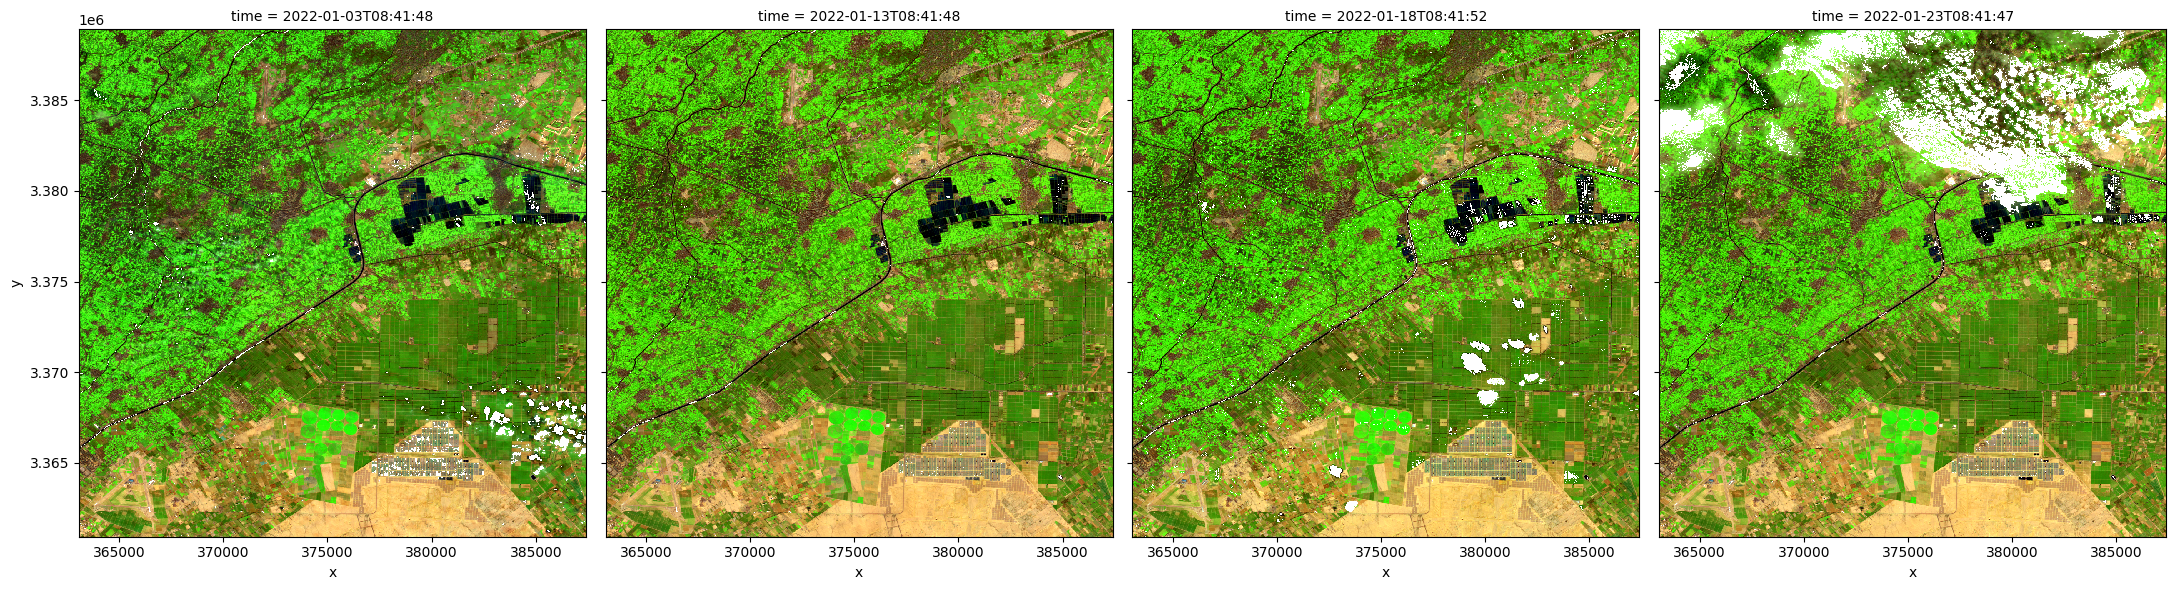

In [10]:
# View a swir_1, nir, green (false colour)
rgb(ds, bands=['swir_1', 'nir', 'green'], col="time")